In [2]:
#Stock market price predictor
#1.stock rises over a period of time
#2.stock market price estimate month wise


In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib as plt

In [26]:
#Data retriving and index manipulation
def input(label):
    ibm=yf.Ticker(label)
    ibm=ibm.history(period="max")
    ibm.to_csv("RCF.NS")
    return ibm
ibm=input("AARTIDRUGS.NS")
ibm=ibm.loc["1990-01-01":].copy()
ibm.index=pd.to_datetime(ibm.index)
ibm.index=ibm.index.date
ibm=ibm.drop(columns=["Dividends" ,"Stock Splits"],errors="ignore")

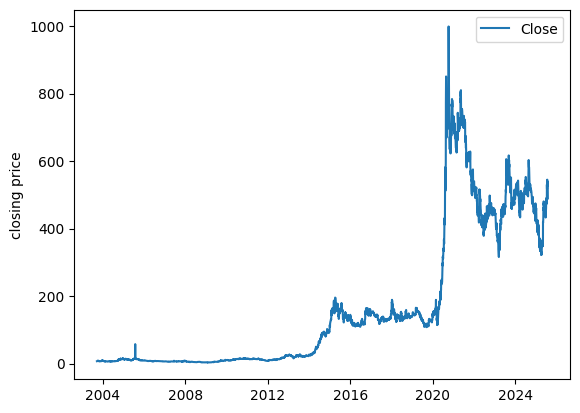

In [27]:
def datavisualisation(dataset):
    dataset.plot.line(y="Close" , ylabel="closing price",legend=["Close"],use_index=True)
datavisualisation(ibm)

In [28]:
#Data splitting 
train=ibm.iloc[:-100]
test=ibm.iloc[-100:]

feature=["High","Open","Low","Volume","Close"]
ibm["Tommorrow"]=ibm["Close"].shift(-1)
ibm["Target"]=(ibm["Tommorrow"]>ibm["Close"]).astype(int)
#model preparation for 1
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(n_estimators=100, min_samples_split=100 ,random_state=1,n_jobs=-1)

def prediction(model , test ,train, feature):
    model.fit(train[feature],train["Target"])
    preds=model.predict_proba(test[feature])[:,1]
    preds[preds>=0.4]=1
    preds[preds<0.4]=0
    preds=pd.Series(preds,index=test.index,name="Predictions")
    preds=pd.concat((preds,test["Target"]),axis=1)
    return preds

In [29]:
#backtracking
def back_tracking(model , data ,feature ,start=2500 ,step=250):
    all_prediction=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[:i].copy()
        test=data.iloc[i:(i+step)].copy()
        predict= prediction(model,test,train,feature)
        all_prediction.append(predict)
    return pd.concat(all_prediction)

In [30]:
#Precision_score
predicts=back_tracking(model,ibm,feature)
from sklearn.metrics import precision_score
precision_score(predicts["Predictions"],predicts["Target"])

0.6620639534883721

In [31]:
predicts["Predictions"].value_counts()

Predictions
1.0    1951
0.0     964
Name: count, dtype: int64

<Axes: ylabel='Closing prices'>

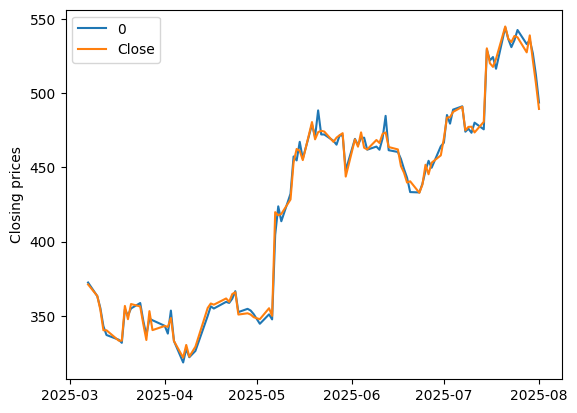

In [32]:
#model 2
from sklearn.linear_model import LinearRegression
feature=["High","Open","Low","Volume"]
m2=LinearRegression()
m2.fit(train[feature],train["Close"])

predsl=m2.predict(test[feature])
predsl=pd.Series(predsl,index=test.index)
combined=pd.concat((predsl,test["Close"]),axis=1)
combined.plot.line(ylabel="Closing prices" ,use_index=True ,legend=["Predicted","Actual"])

In [33]:
predsl

2025-03-07    372.383758
2025-03-10    363.234576
2025-03-11    355.211654
2025-03-12    342.989590
2025-03-13    337.010723
                 ...    
2025-07-28    533.153518
2025-07-29    535.943172
2025-07-30    526.974868
2025-07-31    512.418876
2025-08-01    493.768741
Length: 100, dtype: float64

In [34]:
#precision check

from sklearn.metrics import mean_squared_error ,mean_absolute_error ,r2_score

mse=mean_squared_error(test["Close"],predsl)
mae=mean_absolute_error(test["Close"],predsl)
r2_score=r2_score(test["Close"],predsl)

print("MSE :",mse)
print("MAE :",mae)
print("r2_score :",r2_score)

MSE : 18.73461830794787
MAE : 3.3609282571790744
r2_score : 0.9958512278390715


In [35]:
#Predicting stock price for next month
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM ,Dense


In [36]:
#stationary or not
from statsmodels.tsa.stattools import adfuller
close_series = ibm["Close"]

def check_stationary(series):
    result =adfuller(series)
    print(result[1])

check_stationary(close_series)

0.6387461270256061


In [37]:
#scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
ibm["Close"]=scaler.fit_transform(ibm[["Close"]])

In [38]:
#future dates
from datetime import timedelta
last_row=ibm.iloc[-1].copy()
future_Dates=pd.date_range(last_row.name+timedelta(days=1),periods=30,freq="B")

future_data=pd.DataFrame(index=future_Dates,columns=["Close"])
future_data.index=future_data.index.date


In [39]:
from sklearn.model_selection import train_test_split
closing_price=ibm["Close"].values
def create_dataset(data,lookback):
    feature=[]
    target=[]
    for i in range(len(data)-lookback):
        feature.append(data[i:i+lookback])
        target.append(data[i+lookback])
    return np.array(feature) ,np.array(target)
feat,target=create_dataset(closing_price,lookback=30)

trainfeat=feat[:-100]
testfeat=feat[-100:]
traintarget=target[:-100]
testtarget=target[-100:]

trainfeat=trainfeat.astype('float32')
traintarget=traintarget.astype('float32')
testfeat=testfeat.astype('float32')
trainfeat = np.reshape(trainfeat, (trainfeat.shape[0], trainfeat.shape[1], 1))
testfeat = np.reshape(testfeat, (testfeat.shape[0], testfeat.shape[1], 1))

In [40]:
#LSTm model
modele=Sequential()
modele.add(LSTM(units=50 ,return_sequences=False,input_shape=(30,1)))
modele.add(Dense(units=1))
modele.compile(loss='mean_squared_error', optimizer='adam')
modele.summary()
modele.fit(trainfeat,traintarget,epochs=50 ,batch_size=32,verbose=1)

C:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0030
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2575e-04
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0500e-04
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9530e-04
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7500e-04
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7490e-04
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5058e-04
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3283e-04
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3037e-04
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2249e-04
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2638e-04
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0686e-04
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0320e-04
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1200e-04
Epoch

In [41]:
#Predicting the closing price for next 30 days

def prediction_30_days(modele,dataset,scalar,days=30):

    prediction=[]
    input_seq=dataset[-30:].reshape((-1,30,1)).astype('float32')
    next_preds=0
    for i in range(days):
       next_preds=modele.predict(input_seq)[0][0]
       prediction.append(next_preds)
       input_seq=np.append(input_seq[:,1:,:],[[[next_preds]]],axis=1)
    prediction=np.array(prediction).reshape(-1,1)
    actual_prices=scaler.inverse_transform(prediction)
    
    return actual_prices

scaled_closing=scaler.transform(closing_price.reshape(-1,1))

future_prices=prediction_30_days(modele,scaled_closing,scaler)
future_data["Close"]=future_prices

future_data

pd.concat((ibm , future_data))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

C:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

,Open,High,Low,Close,Volume,Tommorrow,Target
2003-09-19,6.929469,7.202091,6.591744,0.003854,485600.0,7.283473,1.0
2003-09-22,7.014920,7.295680,7.014920,0.004188,1109600.0,7.572368,1.0
2003-09-23,7.478782,7.641541,7.364850,0.004479,472800.0,7.397403,0.0
2003-09-24,7.649680,7.649680,7.332299,0.004303,2187200.0,7.287541,0.0
2003-09-25,7.364852,7.552025,7.275334,0.004193,817600.0,7.633402,1.0
...,...,...,...,...,...,...,...
2025-09-08,NaN,NaN,NaN,88.761490,NaN,NaN,NaN
2025-09-09,NaN,NaN,NaN,92.479828,NaN,NaN,NaN
2025-09-10,NaN,NaN,NaN,96.206619,NaN,NaN,NaN
2025-09-11,NaN,NaN,NaN,99.942719,NaN,NaN,NaN
